In [1]:
import sys
sys.path.insert(0, '..')

from paus_utils import w_central, z_NB

from jpasLAEs.utils import flux_to_mag, bin_centers

import pickle

import numpy as np

from load_paus_mocks import load_mock_dict

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import model_selection

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

In [2]:
def do_this():
    source_cats_dir = '/home/alberto/almacen/Source_cats'
    mock_SFG_path = f'{source_cats_dir}/LAE_12.5deg_z2.55-5_PAUS_0'
    mock_QSO_cont_path = f'{source_cats_dir}/QSO_PAUS_contaminants_2'
    mock_QSO_LAEs_loL_path = f'{source_cats_dir}/QSO_PAUS_LAES_2'
    mock_QSO_LAEs_hiL_path = f'{source_cats_dir}/QSO_PAUS_LAES_hiL_2'
    mock_GAL_path = '/home/alberto/almacen/PAUS_data/catalogs/LightCone_mock.fits'
    mock_dict = load_mock_dict(mock_SFG_path, mock_QSO_cont_path,
                                    mock_QSO_LAEs_loL_path, mock_QSO_LAEs_hiL_path,
                                    mock_GAL_path, gal_fraction=1)

    from load_paus_mocks import add_errors

    for _, cat in mock_dict.items():
        field_name = 'W3'
        cat['flx'], cat['err'] = add_errors(cat['flx_0'], field_name, True)

    mock_dict['GAL'].keys()

    for _, cat in mock_dict.items():
        stack_nb_ids = np.arange(12, 16 + 1)
        synth_BB_flx = np.average(cat['flx'][stack_nb_ids],
                                weights=cat['err'][stack_nb_ids] ** -2,
                                axis=0)
        cat['r_mag'] = flux_to_mag(synth_BB_flx, w_central[-4])

    # Get the minimum number of candidates to set the set length
    N_candidates_list = []
    for mock_name, mock in mock_dict.items():
        N_candidates_list.append(sum(np.isfinite(mock['r_mag'])))

    # set_len = np.min(N_candidates_list) // 10
    set_len = 10_000
    print(N_candidates_list)
    print(f'{set_len=}')

    # Make the set for each class
    tt_set = None
    labels = None
    rmag = None
    zspec = None

    for mock_name, mock in mock_dict.items():
        mock_len = len(mock['zspec'])
        if mock_name == 'SFG':
            print('SFG')
            nice_lya = (mock['zspec'] < 3.5) & np.isfinite(mock['r_mag'])
        else:
            nice_lya = np.isfinite(mock['r_mag'])
        np.random.seed(299792458)
        selection = np.random.choice(np.arange(mock_len)[nice_lya], set_len,
                                    replace=False)
        this_set = np.hstack([
            # mock['flx'][:40, selection].T * 1e17, # NBs
            mock['r_mag'][selection].reshape(-1, 1),
            mock['flx'][40:45, selection].T * 1e17, # BBs
        ])

        if tt_set is None:
            tt_set = this_set
            this_rmag = flux_to_mag(mock['flx'][-4, selection], w_central[-4])
            rmag = this_rmag
            zspec = mock['zspec'][selection]
        else:
            tt_set = np.vstack([tt_set, this_set])

            this_rmag = flux_to_mag(mock['flx'][-4, selection], w_central[-4])
            rmag = np.concatenate([rmag, this_rmag])
            zspec = np.concatenate([zspec, mock['zspec'][selection]])
        

    label_names = []
    labels_list = [1, 2, 3, 3, 4]
    for j in range(len(mock_dict)):
        i = labels_list[j]
        mock_name = list(mock_dict.keys())[j]
        print(f'{i} for {mock_name}')
        if labels is None:
            labels = np.ones(set_len).astype(int) * i
        else:
            labels = np.concatenate([labels, np.ones(set_len).astype(int) * i])
        label_names.append(mock_name)
    label_names.append('?')
    
    return tt_set, rmag, zspec, label_names, labels

tt_set, rmag, zspec, label_names, labels = do_this()

[822701, 87878, 57283, 113938, 2127897]
set_len=10000
SFG
1 for SFG
2 for QSO_cont
3 for QSO_LAEs_loL
3 for QSO_LAEs_hiL
4 for GAL


In [3]:
# Train/Test split
split_seed = 299792458
x_train, x_test, y_train, y_test =\
    model_selection.train_test_split(tt_set, labels, test_size=0.2,
                                     random_state=split_seed)

## Pre-processing ##
# x_train[:, :40] /= np.sum(x_train[:, :40], axis=1).reshape(-1, 1)
# x_train[:, 41:] /= np.sum(x_train[:, 41:], axis=1).reshape(-1, 1)

# x_test[:, :40] /= np.sum(x_test[:, :40], axis=1).reshape(-1, 1)
# x_test[:, 41:] /= np.sum(x_test[:, 41:], axis=1).reshape(-1, 1)
x_train[:, 1:] /= np.sum(x_train[:, 1:], axis=1).reshape(-1, 1)
x_test[:, 1:] /= np.sum(x_test[:, 1:], axis=1).reshape(-1, 1)

x_train[:, 0] /= 30
x_test[:, 0] /= 30

# PCA
# pca = PCA(n_components=0.95, svd_solver='full')

# pca.fit(x_train)
# x_train = pca.transform(x_train)
# x_test = pca.transform(x_test)

print(x_train.shape)

(40000, 6)


In [4]:
def do_grid_search(algorithm, search_mode='random'):
    # Create the parameter grid based on the results of random search
    if algorithm == 'nn':
        param_grid = {
            'hidden_layer_sizes': [(60, 60), (60, 60, 60), (60, 40), (50, 50),
                                   (50, 50, 20), (60, 60, 30)],
            'solver': ['adam'],
            'alpha': [1e-2, 1e-3, 1e-4],
            'batch_size': [50, 100, 250, 300],
            'learning_rate': ['adaptive', 'constant'],
            'max_iter': [10000]
        }
        # Create a based model
        model = MLPClassifier()
    elif algorithm == 'rf':
        param_grid = {
            'random_state': [22],
            'n_estimators': [50, 100, 300, 500, 1000],
            'bootstrap': [True, False],
            'max_depth': [20, 50, 70, 100],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        model = RandomForestClassifier()
    else:
        raise Exception('Model not known')

    # Instantiate the grid search model
    if search_mode == 'grid':
        grid_search = GridSearchCV(
            estimator=model, param_grid=param_grid,
            cv=3, n_jobs=-1, pre_dispatch='2*n_jobs',
            verbose=3,
        )
    elif search_mode == 'random':
        grid_search = RandomizedSearchCV(
            estimator=model, param_distributions=param_grid,
            cv=3, n_jobs=-1, pre_dispatch='2*n_jobs',
            verbose=3,
        )
    else:
        raise Exception('What?')

    grid_search.fit(x_train, y_train)

    return grid_search.best_params_

model = 'nn'
search_mode = 'random'

# best_params = do_grid_search(model, search_mode=search_mode)
if model == 'nn':
    best_params = {'solver': 'adam', 'max_iter': 10000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (60, 60, 60), 'batch_size': 250, 'alpha': 0.001}
elif model == 'rf':
    best_params = {'random_state': 22, 'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': False}
print(best_params)

{'solver': 'adam', 'max_iter': 10000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (60, 60, 60), 'batch_size': 250, 'alpha': 0.001}


In [5]:
if model == 'nn':
    cl_best = MLPClassifier(**best_params)
elif model == 'rf':
    cl_best = RandomForestClassifier(**best_params)

cl_best.fit(x_train, y_train)
test_score = cl_best.score(x_test, y_test)
train_score = cl_best.score(x_train, y_train)
print(f'Score\n\nTrain: {train_score:0.3f}\nTest: {test_score:0.3f}')

Score

Train: 0.892
Test: 0.895


In [13]:
# Predict test
pred_test = cl_best.predict(x_test)
log_p = cl_best.predict_log_proba(x_test)

for src in range(len(pred_test)):
    if pred_test[src] == 4:
        pred_i = 2
    else:
        pred_i = pred_test[src] - 1
    class_log_p = log_p[src, pred_i]
    if class_log_p < np.log(0.88):
        pred_test[src] = 5

In [14]:
# Save the classifier
save_dir = '/home/alberto/almacen/PAUS_data/ML_classifier'
with open(f'{save_dir}/source_classifier_post.sav', 'wb') as file:
    pickle.dump(cl_best, file)
# with open(f'{save_dir}/source_pca_post.sav', 'wb') as file:
#     pickle.dump(pca, file)
# with open(f'{save_dir}/source_scaler_post.sav', 'wb') as file:
#     pickle.dump(scaler, file)

In [15]:
rmag_train, rmag_test =\
    model_selection.train_test_split(rmag, test_size=0.2, random_state=split_seed)
zspec_train, zspec_test =\
    model_selection.train_test_split(zspec, test_size=0.2, random_state=split_seed)

/tmp/ipykernel_278836/3694704777.py:9: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]


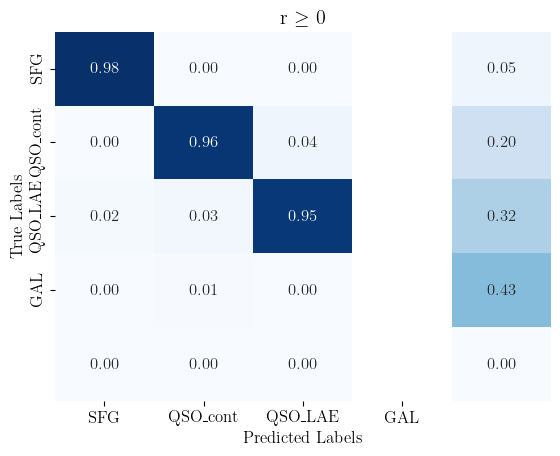

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
r_mask = (rmag_test >= 2)
cm = confusion_matrix(y_test[r_mask], pred_test[r_mask])

# Plot confusion matrix
cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
label_names_cm = ['SFG', 'QSO_cont', 'QSO_LAE', 'GAL']
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.2f',
            xticklabels=label_names_cm, yticklabels=label_names_cm,
            cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title('r $\geq$ 0')
plt.show(block=False)

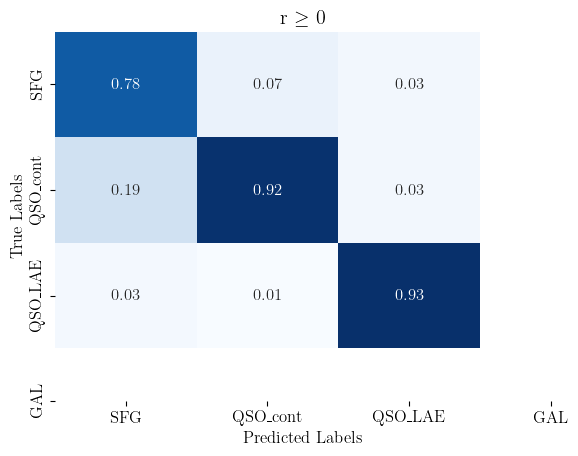

In [10]:
# Compute confusion matrix
r_mask = (rmag_test < 21)
cm = confusion_matrix(y_test[r_mask], pred_test[r_mask])

# Plot confusion matrix
cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
label_names_cm = ['SFG', 'QSO_cont', 'QSO_LAE', 'GAL']
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.2f',
            xticklabels=label_names_cm, yticklabels=label_names_cm,
            cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title('r $\geq$ 0')
plt.show(block=False)

[5.00720080e-124 5.00720080e-124 3.31247558e-001]


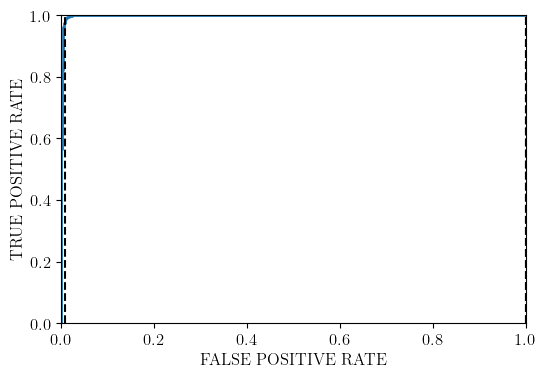

In [11]:
# ROC curves
from sklearn.metrics import roc_curve

# TRUE MEANS CONTAMINANT HERE

y_binary = np.zeros_like(y_test).astype(bool)
y_binary[y_test == 1] = True

sfg_p = np.exp(log_p[:, 0])

fpr, tpr, thresholds = roc_curve(y_binary, sfg_p)

# Compute nice threshold
fpr_thresh_Arr = np.array([0.1, 0.05, 0.01])
thresh_Arr = np.empty_like(fpr_thresh_Arr)
for i, this_fpr in enumerate(fpr_thresh_Arr):
    thresh_Arr[i] = thresholds[fpr >= this_fpr][0]

print(thresh_Arr)

# Represent the ROC curve
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(fpr, tpr, lw=2)
for thr in thresh_Arr:
    # ax.axvline(fpr[thresholds == thr], ls='--', c='k')
    ax.axvline(fpr[thresholds == thr], ls='--', c='k')

ax.set_xlabel('FALSE POSITIVE RATE')
ax.set_ylabel('TRUE POSITIVE RATE')
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

plt.show()